In [0]:
#importing necessary modules in python 


#general
import numpy as np
import pandas as pd
import nltk
import random
import os

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud,STOPWORDS
import warnings
warnings.filterwarnings('ignore')

# Pre-Processing
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix, classification_report


import nltk

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB




from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#reading the data from google drive into python 

train_df = pd.read_csv('/content/drive/My Drive/data science projects/advance/drug review_sentiment/drugsComTrain_raw.csv')
test_df = pd.read_csv('/content/drive/My Drive/data science projects/advance/drug review_sentiment/drugsComTest_raw.csv')


df_full = pd.concat([train_df,test_df])


In [4]:
df_full.head(3)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17


In [5]:
df_full.tail(5)

,uniqueID,drugName,condition,review,rating,date,usefulCount
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,13-Sep-14,43
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,8-Oct-16,11
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8,15-Nov-10,7
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1,28-Nov-11,20
53765,113712,Arthrotec,Sciatica,"""It works!!!""",9,13-Sep-09,46


In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
uniqueID       215063 non-null int64
drugName       215063 non-null object
condition      213869 non-null object
review         215063 non-null object
rating         215063 non-null int64
date           215063 non-null object
usefulCount    215063 non-null int64
dtypes: int64(3), object(4)
memory usage: 13.1+ MB


In [7]:
#looking at the shape of the dataframes

print("the shape of the full df is:",df_full.shape)


the shape of the full df is: (215063, 7)


In [8]:
#checking out for missing valus in the  df

df_full.isnull().sum()

uniqueID          0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64

In [9]:
#checking what percentage of the data is missing from the above dataframe 

percent_missing = df_full.isnull().sum() * 100 / len(df_full)
print(percent_missing)

uniqueID       0.000000
drugName       0.000000
condition      0.555186
review         0.000000
rating         0.000000
date           0.000000
usefulCount    0.000000
dtype: float64


from the above we see that there is very small percentage of values missing , hence we can ignore them for our problem

In [10]:
#looking at the columns of the train_df

df_full.columns.unique()

Index(['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount'],
      dtype='object')

###feature enginering

In [0]:
#creating new columns 

#counting the number of words 
df_full["word count"] = df_full['review'].str.split().apply(len)

#counting the number of letters 
df_full["letter count"] = df_full['review'].apply(len)


#creating boolean for positive and negative review 

df_full["Label"]= 0
df_full.loc[df_full.rating >= 5,["Label"]]=1

In [12]:
df_full.sample(5)

,uniqueID,drugName,condition,review,rating,date,usefulCount,word count,letter count,Label
136002,113420,Bisacodyl,Constipation,"""Used to offset post-op pain medication. Cons...",8,13-Nov-14,1,26,188,1
13547,10573,Mononessa,Birth Control,"""My experience wasn&#039;t that bad! When I fi...",10,13-May-17,10,79,405,1
25082,125956,Viibryd,Depression,"""I have BPD, anxiety disorder, and agoraphobia...",5,20-Feb-15,27,53,300,1
21263,220916,Diclofenac / misoprostol,Osteoarthritis,"""Lupus: I have been taking Arthrotec for two w...",10,14-Nov-11,40,47,276,1
79333,14945,Ethinyl estradiol / norethindrone,Birth Control,"""I&#039;m a week away from finishing my second...",4,4-Aug-17,1,142,784,0


In [13]:
#counting the number of positive and negative datapoints
df_full.Label.value_counts()

1    161491
0     53572
Name: Label, dtype: int64

from the above we see that the data contains more of positive reviews than that of negative reviews

In [0]:
#creating this so that we can perform word cloud

decode_map = {0: "NEGATIVE",1: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [0]:

df_full.target = df_full.Label.apply(lambda x: decode_sentiment(x))
df_full['label_w']= df_full.Label.apply(lambda x: decode_sentiment(x))

In [16]:
df_full.sample(2)

,uniqueID,drugName,condition,review,rating,date,usefulCount,word count,letter count,Label,label_w
53238,134700,Ketorolac,Pain,"""Used Toradol for intractable Migraine Headach...",1,14-Feb-09,29,14,82,0,NEGATIVE
1032,190539,Butorphanol,Labor Pain,"""They gave me Stadol when I was in labor with ...",1,30-Aug-11,14,18,85,0,NEGATIVE


###preprocessing text 

In [17]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup

stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. letters
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower case
    words = letters_only.lower().split()
    # 4. stopwords
    stops = set(stopwords.words('english'))
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    # 6. stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. joining the words
    return( ' '.join(stemming_words))
    #return( ' '.join(words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
df_full['review'] = df_full['review'].apply(review_to_words)

In [19]:
df_full.sample(5)

,uniqueID,drugName,condition,review,rating,date,usefulCount,word count,letter count,Label,label_w
85055,88166,Clindamycin,Bacterial Infection,aw infect along right side gum line includ too...,8,6-May-13,56,135,746,1,POSITIVE
152819,217396,Clarithromycin,Strep Throat,good lord aw worst experi ever drug thing mout...,1,18-Feb-16,15,133,774,0,NEGATIVE
23118,200431,Varenicline,Smoking Cessation,year old smoke sinc year old pack day take cha...,10,30-Sep-13,20,96,482,1,POSITIVE
25088,143772,Etonogestrel,Birth Control,truth anyth posit say form birth control prior...,1,10-Oct-16,10,90,467,0,NEGATIVE
18325,194563,Atorvastatin,High Cholesterol,atorvastatin prescrib year januari woke sever ...,1,6-Apr-15,61,81,471,0,NEGATIVE


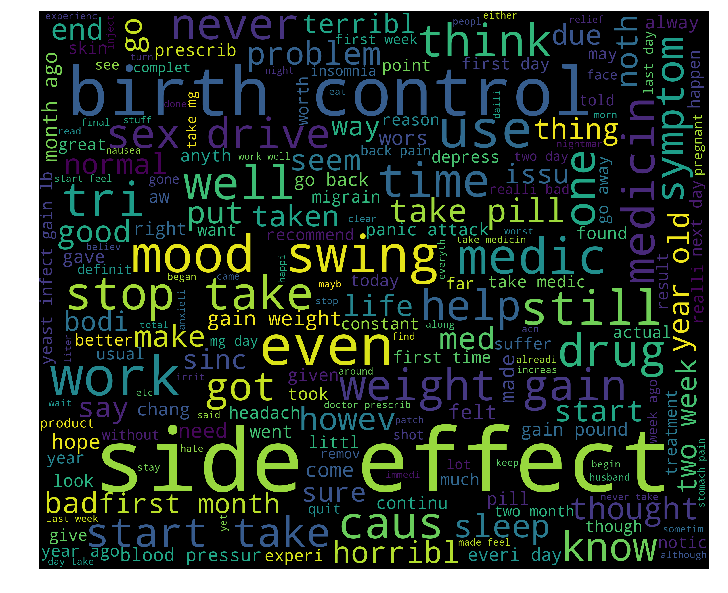

In [20]:
#Wordcloud for Negative sentiments of tweets

from wordcloud import WordCloud,STOPWORDS

new_df=df_full[df_full['label_w']=='NEGATIVE']
words = ' '.join(new_df['review'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='Black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

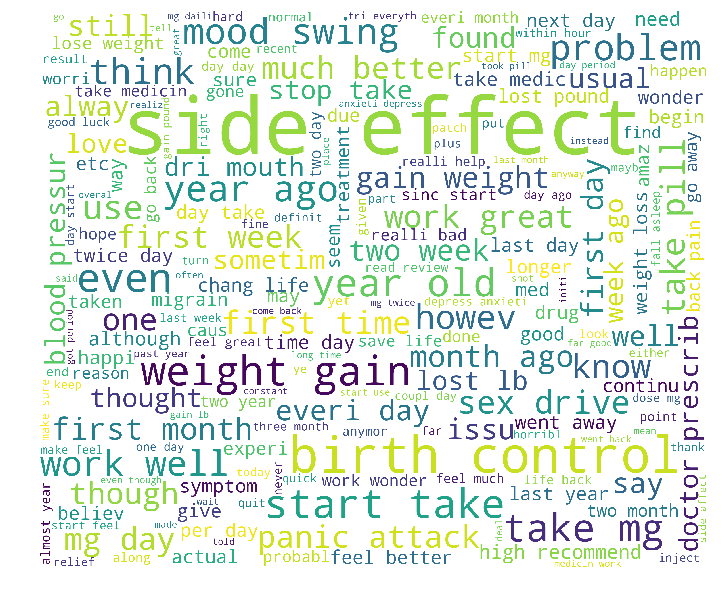

In [21]:
new_df=df_full[df_full['label_w']=='POSITIVE']
words = ' '.join(new_df['review'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

###implementing sentiment analysis

In [22]:
#using multinomialnb

x=df_full['review']
y=df_full['Label']
transformer=CountVectorizer(analyzer='word').fit(x) 
x = transformer.transform(x)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=101)
nb = MultinomialNB()
nb.fit(x_train, y_train)
predict=nb.predict(x_test)
print(confusion_matrix(y_test, predict))
print('\n')
print(classification_report(y_test, predict))

[[ 7011  3613]
 [ 4422 27967]]


              precision    recall  f1-score   support

           0       0.61      0.66      0.64     10624
           1       0.89      0.86      0.87     32389

    accuracy                           0.81     43013
   macro avg       0.75      0.76      0.76     43013
weighted avg       0.82      0.81      0.82     43013



In [23]:
#RandomForestClassifier

#using multinomialnb
from sklearn.svm import LinearSVC
x=df_full['review']
y=df_full['Label']
transformer=CountVectorizer(analyzer='word').fit(x) 
x = transformer.transform(x)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=101)



#defining a model
nb = RandomForestClassifier()

#fit a model
nb.fit(x_train, y_train)

#predict
predict=nb.predict(x_test)
print(confusion_matrix(y_test, predict))
print('\n')
print(classification_report(y_test, predict))

[[ 8145  2479]
 [  890 31499]]


              precision    recall  f1-score   support

           0       0.90      0.77      0.83     10624
           1       0.93      0.97      0.95     32389

    accuracy                           0.92     43013
   macro avg       0.91      0.87      0.89     43013
weighted avg       0.92      0.92      0.92     43013

